In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

import re
import nltk
from nltk.corpus import stopwords
import string
import json


In [2]:
# Read Text Captions
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [3]:
# [:-1] because last caption is empty
captions  = readTextFile("./Data/Flickr_TextData/Flickr8k.token.txt")
captions = captions.split('\n')[:-1] 

In [4]:
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [5]:
print(len(captions))

40460


In [6]:
# dictionary Preperation
descriptions={}

for x in captions:
    first,second=x.split('\t')
    img_id=first.split('.')[0]
    
    if descriptions.get(img_id) is None:
        descriptions[img_id]=[]
    descriptions[img_id].append(second)

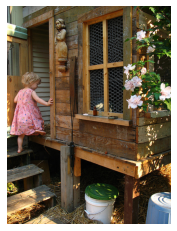

In [7]:
import cv2
IMG_PATH="Data/Images/"

img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

In [8]:
# Lower Case , Remove words less than length 1
def clean_text(sentence):
    sentence=sentence.lower()
    sentence=re.sub("[^a-z]+"," ",sentence)
    sentence=sentence.split(" ")
    
    sentence=[s for s in sentence if len(s)>1]
    sentence=' '.join(sentence)
    return sentence
    

In [9]:
for key,value in descriptions.items():
    for i in range(len(value)):
        value[i]=clean_text(value[i])

In [10]:
# Write the data to text file
with open("descriptions8000_.txt","w") as f:
    f.write(str(descriptions))

In [11]:
descriptions = None
with open("descriptions8000_.txt",'r') as f:
    descriptions= f.read()
    
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [12]:
# Vocab
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size : %d"% len(vocab))

Vocab Size : 8424


In [13]:
# Total No of words across all the sentences
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words %d"%len(total_words))

Total Words 373837


In [14]:
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))

8424


In [15]:
# Sort this dictionary according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# Filter
threshold = 1
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [16]:
print(len(total_words))

5119


In [17]:
train_file_data = readTextFile("Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [18]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [19]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [20]:
# Prepare Description for the Training Data
# Tweak - Add <s> and <e> token to our training data
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq "  + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [21]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [22]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [23]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [24]:
model_new = Model(model.input,model.layers[-2].output)

In [25]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

In [26]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [27]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")

array([0.06535921, 0.16782534, 0.3251761 , ..., 0.05107138, 0.32821208,
       1.0043364 ], dtype=float32)

In [28]:
train[0]

'2513260012_03d33305cf'

In [29]:
import pickle
encoding_test = pickle.load(open('saved/test.pkl', 'rb'))
encoding_train = pickle.load(open('saved/encoded_train_features.pkl', 'rb'))

In [30]:
# Vocab
len(total_words)

5119

In [31]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [32]:
#word_to_idx["dog"]
#idx_to_word[1]
print(len(idx_to_word))

5119


In [33]:
# Two special words
idx_to_word[5120] = 'startseq'
word_to_idx['startseq'] = 5120

idx_to_word[5121] = 'endseq'
word_to_idx['endseq'] = 5121

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 5122


In [34]:
max_len = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

35


In [35]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [36]:
f = open("./saved/glove.6B.50d.txt",encoding='utf8')

In [37]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding
    

In [38]:
f.close()

In [39]:
embedding_index['apple']
len(embedding_index)

400000

In [40]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [41]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(5122, 50)

In [42]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [43]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [44]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=(input_img_features,input_captions),outputs=outputs)

In [45]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       256100      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [46]:
# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix])

model.layers[2].trainable = False

In [47]:
# Run it once , And save the model 
# model.compile(loss='categorical_crossentropy',optimizer="adam")
# epochs = 1
# batch_size = 3
# steps = len(train_descriptions)//batch_size
# def train():
    
#     for i in range(epochs):
#         generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
#         model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
#         model.save('./model_weights/models_8000_'+str(i)+'.h5')
# train()

In [51]:
model = load_model('./model_weights/models_8000_resnet50_49.h5')

In [52]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

In [53]:
def beam_search_predictions(image, beam_index = 3):
    start = [word_to_idx["startseq"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = encoding_test[image[len(images):-4]]
            preds = model.predict([np.array([e]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx_to_word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [61]:
def f(im):
    return beam_search_predictions(im, beam_index=7)

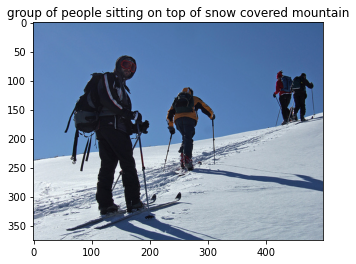

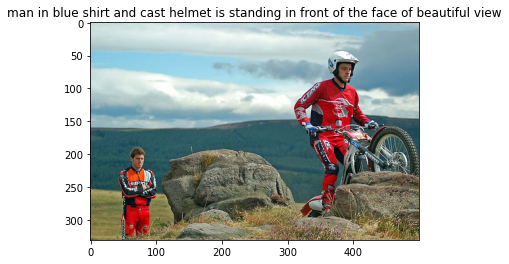

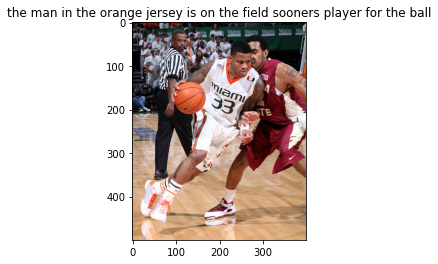

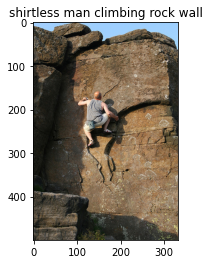

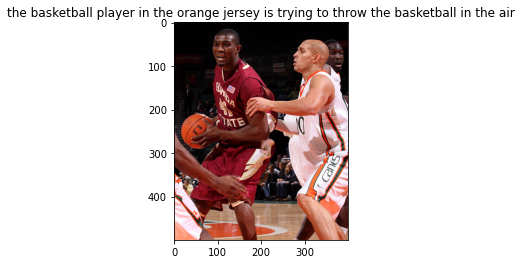

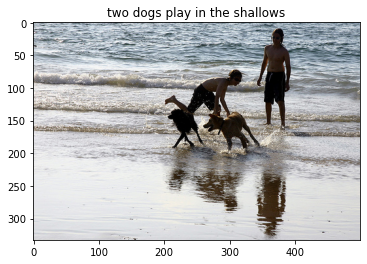

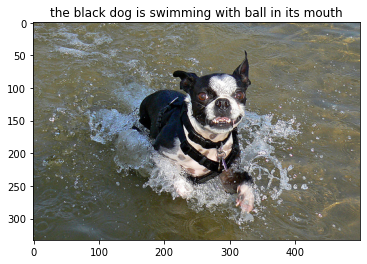

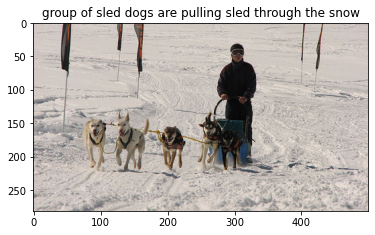

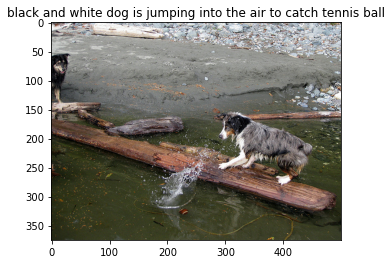

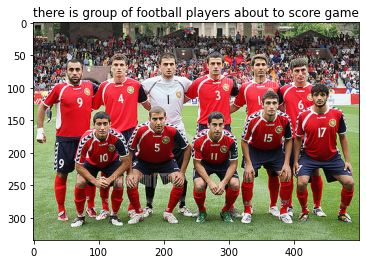

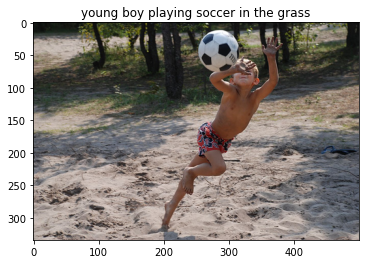

In [62]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# images = 'Data/Images/'
# arr=[494,853,713,224,480,728,307,133,205,533,209]

# for i in range(0,len(arr)):
#     im='Data/Images/'+test[arr[i]]+'.jpg'
#     img2 = mpimg.imread(im)
#     imgplot = plt.imshow(img2)
#     plt.title(f(im))
#     plt.show()

Beam Search, k=3: man in blue shirt is jumping on his bike
Beam Search, k=5: man is doing tricks on his bike in front of white building
Beam Search, k=7: bike rider flies through the air above the ocean
None


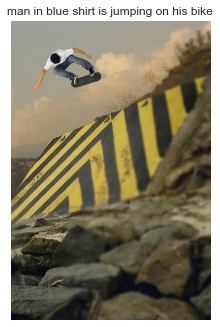

Beam Search, k=3: woman in red shirt is standing in front of crowd of people
Beam Search, k=5: group of people are standing in front of some bushes
Beam Search, k=7: group of young men pose for picture in front of crowd
None


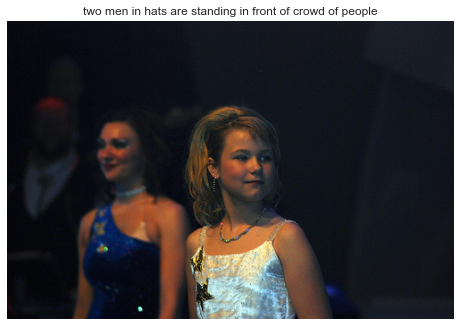

Beam Search, k=3: two black dogs are playing in the grass
Beam Search, k=5: two black dogs are playing in the grass
Beam Search, k=7: two black dogs are playing in the grass
None


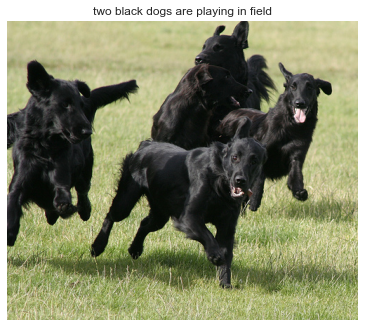

Beam Search, k=3: little girl in blue shorts is running through the grass
Beam Search, k=5: little girl in blue shorts is running through the grass
Beam Search, k=7: little girl in blue shorts is running through the grass
None


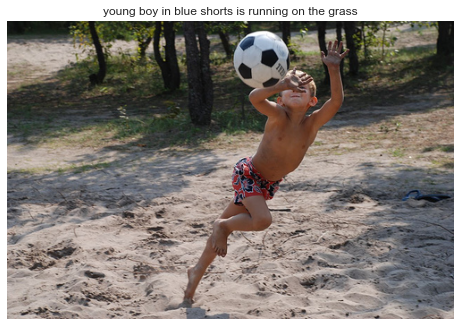

Beam Search, k=3: man in black jacket and black shirt is standing on tripod
Beam Search, k=5: group of people sit on bench in front of brick wall
Beam Search, k=7: group of people standing in front of building
None


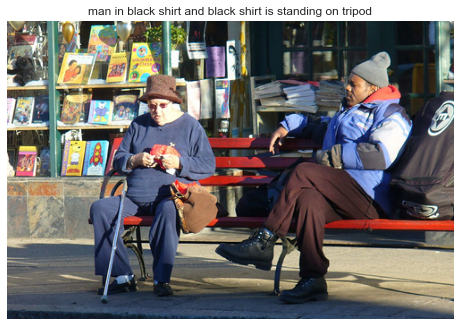

In [53]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(0,1):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    im="Data/Images/"+img_name+".jpg"
    i = plt.imread(im)
    print(f(im))
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    

In [58]:
gloveFile = "./saved/glove.6B.50d.txt"
import numpy as np
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    with open(gloveFile, encoding="utf8" ) as f:
        content = f.readlines()
    m = {}
    for line in content:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        m[word] = embedding
    print ("Done.",len(m)," words loaded!")
    return m

import re
from nltk.corpus import stopwords
import pandas as pd

def preprocess(raw_text):

    # keep only words
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

    # convert to lower case and split 
    words = letters_only_text.lower().split()

    # remove stopwords
    stopword_set = set(stopwords.words("english"))
    cleaned_words = list(set([w for w in words if w not in stopword_set]))

    return cleaned_words

def cosine_distance_between_two_words(word1, word2):
    import scipy
    return (1- scipy.spatial.distance.cosine(m[word1], m[word2]))

def cosine_distance_wordembedding_method(s1, s2):
    import scipy
    v=0
    c=0
    for word in preprocess(s1):
        if(word in m):
            v=v+m[word]
            c=c+1
    v1=v/c
    v=0
    c=0
    for word in preprocess(s2):
        if(word in m):
            v=v+m[word]
            c=c+1
    v2=v/c
    
    
    
#     v1 = np.mean([m[word] for word in preprocess(s1)],axis=0)
#     v2 = np.mean([m[word] for word in preprocess(s2)] ,axis=0)
    cosine = scipy.spatial.distance.cosine(v1, v2)
    return round((1-cosine)*100,2)

In [59]:
m = loadGloveModel(gloveFile)

Loading Glove Model
Done. 400000  words loaded!


In [60]:
im='Data/Images/'+test[0]+'.jpg'
Y=beam_search_predictions(im, beam_index=3)
avg=0
for i in range(0,5):
    X=descriptions[test[0]][i]
    avg=max(avg,cosine_distance_wordembedding_method(X,Y))

print(avg)

97.5


In [ ]:
avg=0
n=1000
for i in range(0,n):
    im='Data/Images/'+test[i]+'.jpg'
    Y=beam_search_predictions(im, beam_index=7)
    max_avg=0
    for j in range(0,5):
        X=descriptions[test[0]][j]
        max_avg=max(max_avg,cosine_distance_wordembedding_method(X,Y))
    avg+=max_avg
    print('Currently at image '+str(i)+' '+str(avg))
print(avg/n)